# UK Validation of ECMWF ERA5 model runs CCI satilite SST

In [101]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import iris.coord_categorisation
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import iris.coord_categorisation
import glob
import pandas as pd
import datetime


In [3]:
def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region


def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)


def common_years(cube1,cube2):
    cube1_yrs = cube1.coord('year').points
    cube2_yrs = cube2.coord('year').points
    years= np.intersect1d(cube1_yrs,cube2_yrs)
    cube1_ind= np.in1d(cube1_yrs,cube2_yrs)
    cube2_ind= np.in1d(cube2_yrs,cube1_yrs)
    return years,cube1.data[cube1_ind],cube2.data[cube2_ind]


def compariable_across_grids(cube1,cube2,lon_west,lon_east,lat_south,lat_north):
    cube1_region = extract_region(cube1,lon_west,lon_east,lat_south,lat_north)
    cube2_region = extract_region(cube2,lon_west,lon_east,lat_south,lat_north)
    
    cube2_region.coord('latitude').coord_system = cube1_region.coord('latitude').coord_system
    cube2_region.coord('longitude').coord_system =cube1_region.coord('longitude').coord_system

    cube1_region_regridded = cube1_region.regrid(cube2_region, iris.analysis.Linear())
    cube2_region.data.mask = cube1_region_regridded.data.mask


    cube2_region.data[np.where(cube2_region.data < -20.0)] = cube2_region.data.fill_value
    cube2_region.data[np.where(cube2_region.data >100.0)] = cube2_region.data.fill_value
    cube2_region.data = np.ma.masked_where(cube2_region.data == cube2_region.data.fill_value, cube2_region.data)

    cube1_region_regridded.data[np.where(cube1_region_regridded.data < -20.0)] = cube1_region_regridded.data.fill_value
    cube1_region_regridded.data[np.where(cube1_region_regridded.data > 100.0)] = cube1_region_regridded.data.fill_value
    cube1_region_regridded.data = np.ma.masked_where(cube1_region_regridded.data == cube1_region_regridded.data.fill_value, cube1_region_regridded.data)
    return cube1_region_regridded,cube2_region


def select_range(cube, my_range):
    return cube[np.where((cube.coord('year').points > my_range[0]) & (cube.coord('year').points < my_range[1]))]


def add_year(cube):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    return cube

In [42]:
file = '/Users/ph290/Downloads/UK/era5_uk_surfacechlorophyll_mm.nc'


# file = '/Users/ph290/Downloads/global_tropics/surface_temperature_global_tropics_era5_year_mean_mv.nc'
# file = '/Users/ph290/Downloads/global_tropics/surface_temperature_global_tropics_era5.nc'
year_for_basic_comparison = 2010
min_year_for_comparison = 1997
max_year_for_comparison = 2017
season_for_analysis = 'djf'

In [36]:
# obs_cube = iris.load_cube('/Users/ph290/Downloads/global_tropics/coraltemp_v1.0_19890101.nc','sea_surface_temperature')[0]
# obs_cube = iris.load_cube('/Users/ph290/Downloads/global_tropics/coraltemp_v1.0_1989.nc','sea_surface_temperature')
obs_cube_all = iris.load_cube('/Users/ph290/Downloads/obs_data/CCI_ALL-v4.2-MONTHLY_region.nc')
# copied from groupserv:/data/BatCaveNAS/ph290/obs/
# obs_cube = iris.load_cube('/Users/ph290/Downloads/global_tropics/coraltemp_v1.0_2008_all_tm.nc','sea_surface_temperature')

In [5]:
def select_season(cube,my_season):
    try:
        iris.coord_categorisation.add_season(cube, 'time',name='season')
    except:
        pass
    return cube[np.where(cube.coord('season').points == my_season)]




In [37]:
obs_cube_all = select_season(obs_cube_all,season_for_analysis)

obs_cube_all_monthly = obs_cube_all.copy()


try:
    iris.coord_categorisation.add_year(obs_cube_all, 'time', name='year')
except:
    pass

obs_cube_all = obs_cube_all.aggregated_by('year', iris.analysis.MEAN)

print obs_cube_all.coord('year').points


obs_cube = obs_cube_all[np.where((obs_cube_all.coord('year').points >= min_year_for_comparison) & (obs_cube_all.coord('year').points <= max_year_for_comparison))]
obs_cube_ym = obs_cube.copy()
obs_cube = obs_cube.collapsed('time',iris.analysis.MEAN)
# obs_cube = obs_cube_all[np.where(obs_cube_all.coord('year').points == year_for_basic_comparison)]



[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019]


In [43]:
cube_all = iris.load_cube(file)

cube_all_monthly = cube_all.copy()

cube_all = select_season(cube_all,season_for_analysis)


try:
    iris.coord_categorisation.add_year(cube_all, 'time', name='year')
except:
    pass

cube_all = cube_all.aggregated_by('year', iris.analysis.MEAN)


# cube_all.coord('longitude').points = cube_all.coord('longitude').points+180
# cube_all.data = np.ma.masked_array(cube_all.data)
# cube_all.data.fill_value = 9.96920997e+36
cube_all.data = np.ma.masked_where(cube_all.data == 9.96920997e+36, cube_all.data)
# iris.coord_categorisation.add_year(cube_all, 'time', name='year')
cube = cube_all[np.where((cube_all.coord('year').points >= min_year_for_comparison) & (cube_all.coord('year').points <= max_year_for_comparison))]
cube_ym = cube.copy()
cube = cube.collapsed('time',iris.analysis.MEAN)

In [8]:
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

## Directly comparing model and satilite on common grids (regridding model to satilite grid)

basically we've got to the point where the areas where it is hot/cold relate to warm/cold currents. In warm conditions where density is ~linaerly dependent on temperature this is probably not an issue, and we can be confident in the variability, but at high latitudes, one would probably want to corrent the temperatures to ensure the density was responding appropriately to variability. In future runs, if theer was evidence that that there was a chnge in teh large-scale currents feeding an area, that could also be factored in, based on the assumption that the difference between the ECMWF run and observed SST.

## Model minus CCI satilite Chl A with depth plotted as contours

Comparison of annual mean for year specified at the top of the page

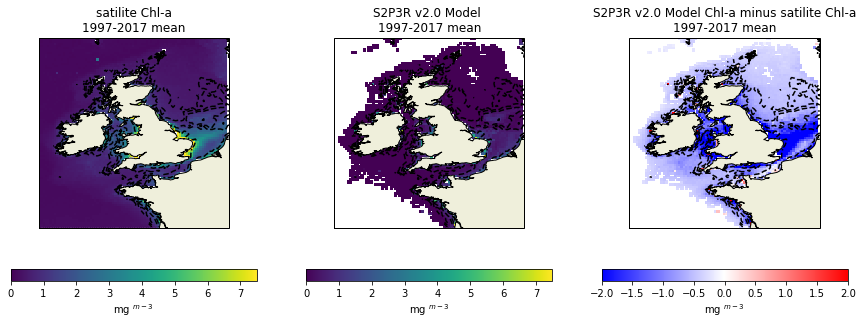

In [9]:
lon_west = -12.0
lon_east = 5.0
lat_south = 45.0
lat_north = 62.0



c_model = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
# c_model.coord('longitude').points = c_model.coord('longitude').points + 180

c_cci_region = extract_region(obs_cube,lon_west,lon_east,lat_south,lat_north)

c_model.coord('latitude').coord_system = c_cci_region.coord('latitude').coord_system
c_model.coord('longitude').coord_system =c_cci_region.coord('longitude').coord_system

c_cci_region_regridded = c_cci_region.regrid(c_model, iris.analysis.Linear())
# obs_cube_all_region.data.mask = obs_cube_all_region_regridded.data.mask

# model_data = iris.analysis.maths.log(c_model/10.0).data
model_data = (c_model/10.0).data
lat_model = c_model.coord('latitude').points
lon_model = c_model.coord('longitude').points


# cci_data = iris.analysis.maths.log(c_cci_region_regridded).data
cci_data = c_cci_region_regridded.data
lat_cci = c_cci_region_regridded.coord('latitude').points
lon_cci = c_cci_region_regridded.coord('longitude').points


bathy_file = '/Users/ph290/Downloads/ETOPO1_Bed_g_gmt4_low_res.nc'
bathy_cube = iris.load_cube(bathy_file)
bathy_cube.data = np.ma.masked_where(bathy_cube.data >= 0.0,bathy_cube.data)
bathy_cube.data = np.ma.masked_where(bathy_cube.data < -100.0,bathy_cube.data)



bathy_cube = extract_region(bathy_cube,lon_west,lon_east,lat_south,lat_north)

bathy_data = bathy_cube.data
lat_bathy = bathy_cube.coord('latitude').points
lon_bathy = bathy_cube.coord('longitude').points

lon_west2 = lon_west
lon_east2 = lon_east
lat_south2 = lat_south
lat_north2 = lat_north

plt.close('all')
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())


#####################

ax1.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

ax1.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')

p1 = ax1.pcolormesh(lon_cci, lat_model,cci_data,
                transform=ccrs.PlateCarree(),
                vmin=0.0,vmax=7.5,
                cmap='viridis')
# plt.colorbar(p1)
cbar1 = fig.colorbar(p1,orientation='horizontal', ax=ax1)
# cbar1 = plt.colorbar(p1,orientation='horizontal')
# cbar1.set_label('log(mg $^{m-3}$)')
cbar1.set_label('mg $^{m-3}$')

ax1.add_feature(land_10m, edgecolor='k')

ax1.title.set_text('satilite Chl-a\n1997-2017 mean')

#####################

ax2.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

ax2.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')

p2 = ax2.pcolormesh(lon_cci, lat_model,model_data,
                transform=ccrs.PlateCarree(),
                vmin=0.0,vmax=7.5,
                cmap='viridis')
# plt.colorbar(p1)
cbar2 = fig.colorbar(p2,orientation='horizontal', ax=ax2)
# cbar1 = plt.colorbar(p1,orientation='horizontal')
# cbar2.set_label('log(mg $^{m-3}$)')
cbar2.set_label('mg $^{m-3}$')

ax2.add_feature(land_10m, edgecolor='k')

ax2.title.set_text('S2P3R v2.0 Model \n1997-2017 mean')


#####################

# ax3 = plt.axes(projection=ccrs.PlateCarree())
ax3.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

# ax3 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax3.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')

p3 = ax3.pcolormesh(lon_cci, lat_model,model_data - cci_data,
                transform=ccrs.PlateCarree(),vmin=-2,vmax=2,
                cmap='bwr')
# plt.colorbar(p3)
cbar3 = fig.colorbar(p3,orientation='horizontal', ax=ax3)
# cbar = plt.colorbar(p3,orientation='horizontal')
# cbar1.set_label('log(mg $^{m-3}$)')
cbar3.set_label('mg $^{m-3}$')

ax3.add_feature(land_10m, edgecolor='k')

ax3.title.set_text('S2P3R v2.0 Model Chl-a minus satilite Chl-a\n1997-2017 mean')

#################

plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/uk_chla_validation_map.png',dpi=300)




## timeseries comparison model v. CCI

In [10]:
model_region_regridded,obs_region = compariable_across_grids(cube_ym,obs_cube_ym,-20,5,45,70)
# model_bottom_region_regridded,obs_region = compariable_across_grids(cube_all_bottom,obs_cube_all,142,156,-29,-10)


In [11]:
# lon_west = -2.5
# lon_east = 5.0
# lat_south = 51
# lat_north = 59
# cube_all_region_area_avg_1 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
# obs_cube_all_region_area_avg_1 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))
# lon_west = -5.5
# lon_east = 1.5
# lat_south = 48.5
# lat_north = 51.0
# cube_all_region_area_avg_2 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
# obs_cube_all_region_area_avg_2 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))
# lon_west = -6.5
# lon_east = -2.5
# lat_south = 51.0
# lat_north = 55.5
# cube_all_region_area_avg_3 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
# obs_cube_all_region_area_avg_3 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))


# def common_years(cube1,cube2):
#     cube1_yrs = cube1.coord('year').points
#     cube2_yrs = cube2.coord('year').points
#     years= np.intersect1d(cube1_yrs,cube2_yrs)
#     print years
#     cube1_ind= np.in1d(cube1_yrs,cube2_yrs)
#     print cube1_ind
#     cube2_ind= np.in1d(cube2_yrs,cube1_yrs)
#     print cube2_ind
#     return years,cube1.data[cube1_ind],cube2.data[cube2_ind]


# yr,y1,y2 = common_years(cube_all_region_area_avg_1,obs_cube_all_region_area_avg_1)

# print np.shape(yr)
# print np.shape(y1)
# print np.shape(y2)



In [12]:
# cube1 = cube_all_region_area_avg_1.copy()
# cube2 = obs_cube_all_region_area_avg_1.copy()
# cube1_yrs = cube1.coord('year').points
# print cube1_yrs
# cube2_yrs = cube2.coord('year').points
# print cube2_yrs
# years= np.intersect1d(cube1_yrs,cube2_yrs)
# cube1_ind= np.in1d(cube1_yrs,cube2_yrs)
# print cube1_ind
# cube2_ind= np.in1d(cube2_yrs,cube1_yrs)
# print cube2_ind
# print years
# print cube1.data[cube1_ind]
# print cube2.data[cube2_ind]

*thoughts:* is the model drifting to the right temperature after a long spinup stage? Start the run earlier and/or change the initialisation temperature and re-run.

## plotting by region


/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/analysis/cartography.py:376: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/Users/ph290/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


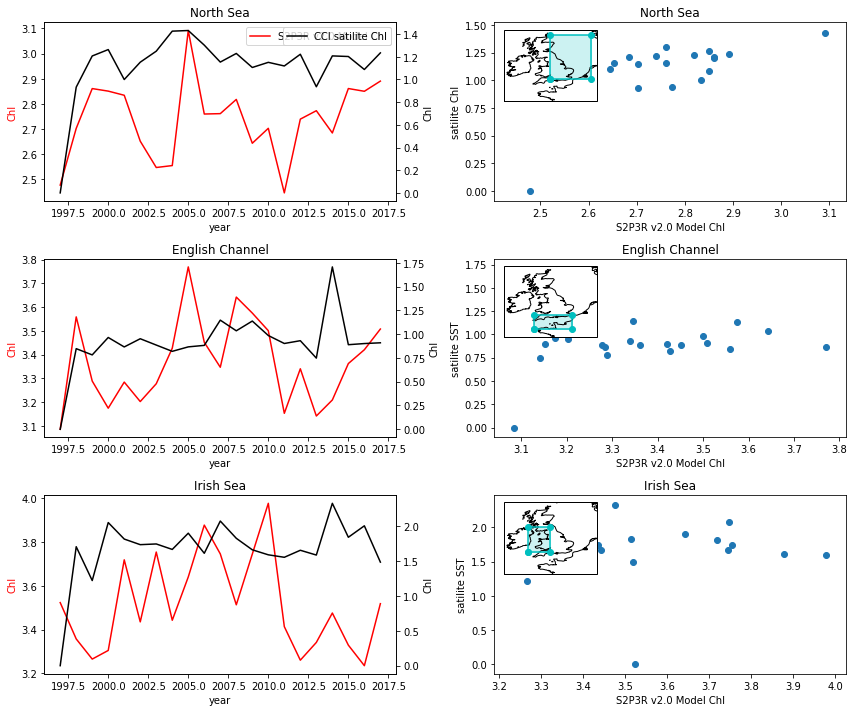

In [13]:
# plotting_range = [1997,2017]
# model_region_regridded = select_range(model_region_regridded, plotting_range)
# obs_region = select_range(obs_region, plotting_range)

projection=ccrs.PlateCarree()

lon_west = -2.5
lon_east = 5.0
lat_south = 51
lat_north = 59
cube_all_region_area_avg_1 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_1 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))
lon_west = -5.5
lon_east = 1.5
lat_south = 48.5
lat_north = 51.0
cube_all_region_area_avg_2 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_2 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))
lon_west = -6.5
lon_east = -2.5
lat_south = 51.0
lat_north = 55.5
cube_all_region_area_avg_3 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_3 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))


fig,axes= plt.subplots(nrows=3, ncols=2,figsize=(12, 10))

yr,y1,y2 = common_years(cube_all_region_area_avg_1,obs_cube_all_region_area_avg_1)

axes[0,0].plot(yr,y1,'r',label='S2P3R v2.0 Model Chl')
ax00b = axes[0,0].twinx() 
ax00b.plot(yr,y2,'k',label='CCI satilite Chl')
axes[0,0].set_title('North Sea')
axes[0,0].set_ylabel('Chl', color='r') 
ax00b.set_ylabel('Chl', color='k') 


axes[0,1].scatter(y1,y2,label='S2P3R v2.0 Model Chl v. satilite Chl')
axes[0,1].set_xlabel('S2P3R v2.0 Model Chl')
axes[0,1].set_ylabel('satilite Chl')
# axes[0,1].plot([0,100],[0,100])
# axes[0,1].set_xlim([8.5,11.7])
# axes[0,1].set_ylim([8.5,11.7])
axes[0,1].set_title('North Sea')

yr,y1,y2 = common_years(cube_all_region_area_avg_2,obs_cube_all_region_area_avg_2)

axes[1,0].plot(yr,y1,'r',label='S2P3R v2.0 Model SST')
ax10b = axes[1,0].twinx() 
ax10b.plot(yr,y2,'k',label='CCI satilite Chl')
axes[1,0].set_title('English Channel')
axes[1,0].set_ylabel('Chl', color='r') 
ax10b.set_ylabel('Chl', color='k') 

axes[1,1].scatter(y1,y2,label='S2P3R v2.0 Model Chl v. satilite Chl')
axes[1,1].set_xlabel('S2P3R v2.0 Model Chl')
axes[1,1].set_ylabel('satilite SST')
# axes[1,1].plot([0,100],[0,100])
# axes[1,1].set_xlim([11.0,14.0])
# axes[1,1].set_ylim([11.0,14.0])
axes[1,1].set_title('English Channel')

yr,y1,y2 = common_years(cube_all_region_area_avg_3,obs_cube_all_region_area_avg_3)

axes[2,0].plot(yr,y1,'r',label='S2P3R v2.0 Model Chl')
ax20b = axes[2,0].twinx() 
ax20b.plot(yr,y2,'k',label='CCI satilite Chl')
axes[2,0].set_title('Irish Sea')
axes[2,0].set_ylabel('Chl', color='r') 
ax20b.set_ylabel('Chl', color='k') 

axes[2,1].scatter(y1,y2,label='S2P3R v2.0 Model Chl v. satilite Chl')
axes[2,1].set_xlabel('S2P3R v2.0 Model Chl')
axes[2,1].set_ylabel('satilite SST')
# axes[2,1].plot([0,100],[0,100])
# axes[2,1].set_xlim([9.5,12.5])
# axes[2,1].set_ylim([9.5,12.5])
axes[2,1].set_title('Irish Sea')

axes[0,0].legend(fancybox=True)
ax00b.legend(loc=1,fancybox=True)

axes[0,0].set_xlabel('year', color='k') 
axes[1,0].set_xlabel('year', color='k') 
axes[2,0].set_xlabel('year', color='k') 


inset_x = 0
inset_y = 1
inset_size = 0.4

inset_ax1 = plt.axes([0, 0, 1, 1], projection=projection)
inset_ax1.set_extent([-11, 6, 47, 60], ccrs.PlateCarree())
inset_ax1.coastlines('50m')
ip1 = InsetPosition(axes[0,1], [inset_x - inset_size*0.1,
                        inset_y - inset_size*1.1,
                        inset_size,
                        inset_size])
inset_ax1.set_axes_locator(ip1)
lon_west = -2.5
lon_east = 5.0
lat_south = 51
lat_north = 59
x, y = [lon_west, lon_west, lon_east, lon_east, lon_west], [lat_south, lat_north, lat_north, lat_south,lat_south]
inset_ax1.plot(x, y, 'c',marker='o', transform=projection)
inset_ax1.fill(x, y, color='c', transform=projection, alpha=0.2)


inset_ax2 = plt.axes([0, 0, 2, 2], projection=projection)
inset_ax2.set_extent([-11, 6, 47, 60], ccrs.PlateCarree())
inset_ax2.coastlines('50m')
ip2 = InsetPosition(axes[1,1], [inset_x - inset_size*0.1,
                        inset_y - inset_size*1.1,
                        inset_size,
                        inset_size])
inset_ax2.set_axes_locator(ip2)
lon_west = -5.5
lon_east = 1.5
lat_south = 48.5
lat_north = 51.0
x, y = [lon_west, lon_west, lon_east, lon_east, lon_west], [lat_south, lat_north, lat_north, lat_south,lat_south]
inset_ax2.plot(x, y, 'c',marker='o', transform=projection)
inset_ax2.fill(x, y, color='c', transform=projection, alpha=0.2)


inset_ax3 = plt.axes([0, 0, 3, 3], projection=projection)
inset_ax3.set_extent([-11, 6, 47, 60], ccrs.PlateCarree())
inset_ax3.coastlines('50m')
ip3 = InsetPosition(axes[2,1], [inset_x - inset_size*0.1,
                        inset_y - inset_size*1.1,
                        inset_size,
                        inset_size])
inset_ax3.set_axes_locator(ip3)
lon_west = -6.5
lon_east = -2.5
lat_south = 51.0
lat_north = 55.5
x3, y3 = [lon_west, lon_west, lon_east, lon_east, lon_west], [lat_south, lat_north, lat_north, lat_south,lat_south]
inset_ax3.plot(x3, y3, 'c',marker='o', transform=projection)
inset_ax3.fill(x3, y3, color='c', transform=projection, alpha=0.2)

plt.tight_layout()


plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/uk_chl_validation1.pdf')
plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/uk_chl_validation1.png')

plt.tight_layout()



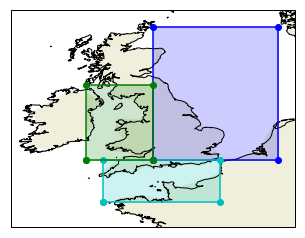

In [14]:

projection = ccrs.PlateCarree()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=projection)

ax.set_extent([-11, 6, 47, 60], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.coastlines('10m')

lon_west = -2.5
lon_east = 5.0
lat_south = 51
lat_north = 59
x, y = [lon_west, lon_west, lon_east, lon_east, lon_west], [lat_south, lat_north, lat_north, lat_south,lat_south]
ax.plot(x, y, 'b',marker='o', transform=projection)
ax.fill(x, y, color='b', transform=projection, alpha=0.2)

lon_west = -5.5
lon_east = 1.5
lat_south = 48.5
lat_north = 51.0
x, y = [lon_west, lon_west, lon_east, lon_east, lon_west], [lat_south, lat_north, lat_north, lat_south,lat_south]
ax.plot(x, y, 'c',marker='o', transform=projection)
ax.fill(x, y, color='c', transform=projection, alpha=0.2)

lon_west = -6.5
lon_east = -2.5
lat_south = 51.0
lat_north = 55.5
x, y = [lon_west, lon_west, lon_east, lon_east, lon_west], [lat_south, lat_north, lat_north, lat_south,lat_south]
ax.plot(x, y, 'g',marker='o', transform=projection)
ax.fill(x, y, color='g', transform=projection, alpha=0.2)

# ax.gridlines()

## Monthly analysis

In [76]:
file = '/Users/ph290/Downloads/UK/era5_uk_surfacechlorophyll_mm.nc'

year_for_basic_comparison = 2010
min_year_for_comparison = 1998
max_year_for_comparison = 2018

obs_cube_all_monthly = iris.load_cube('/Users/ph290/Downloads/obs_data/CCI_ALL-v4.2-MONTHLY_region.nc')
cube_all_monthly = iris.load_cube(file)
cube_all_monthly.data = np.ma.masked_where(cube_all_monthly.data == cube_all_monthly.data.max(),cube_all_monthly.data)


def add_year(cube):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    return cube

def add_month(cube):
    try:
        iris.coord_categorisation.add_month_number(cube, 'time', name='month')
    except:
        pass
    return cube

obs_cube_all_monthly = add_year(obs_cube_all_monthly)
obs_cube_all_monthly = add_month(obs_cube_all_monthly)

obs_cube_all_monthly = obs_cube_all_monthly[np.where((obs_cube_all_monthly.coord('year').points >= min_year_for_comparison) & (obs_cube_all_monthly.coord('year').points <= max_year_for_comparison))]

cube_all_monthly = add_year(cube_all_monthly)
cube_all_monthly = add_month(cube_all_monthly)

cube_all_monthly = cube_all_monthly[np.where((cube_all_monthly.coord('year').points >= min_year_for_comparison) & (cube_all_monthly.coord('year').points <= max_year_for_comparison))]


/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:280: UserWarning: Missing CF-netCDF ancillary data variable u'chlor_a_log10_rmsd', referenced by netCDF variable u'chlor_a'
  warnings.warn(message % (name, nc_var_name))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:280: UserWarning: Missing CF-netCDF ancillary data variable u'chlor_a_log10_bias', referenced by netCDF variable u'chlor_a'
  warnings.warn(message % (name, nc_var_name))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [77]:
obs_cube_all_monthly_mon_means = obs_cube_all_monthly.aggregated_by('month',iris.analysis.MEAN)
cube_all_monthly_mon_means = cube_all_monthly.aggregated_by('month',iris.analysis.MEAN)

cube_all_monthly_mon_means.data = np.ma.masked_where(cube_all_monthly_mon_means.data == cube_all_monthly_mon_means.data.max(),cube_all_monthly_mon_means.data)


/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/cube.py:3281: UserWarning: Collapsing spatial coordinate u'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:1017: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'latitude'.
  warnings.warn(msg.format(self.name()))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:1017: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'longitude'.
  warnings.warn(msg.format(self.name()))


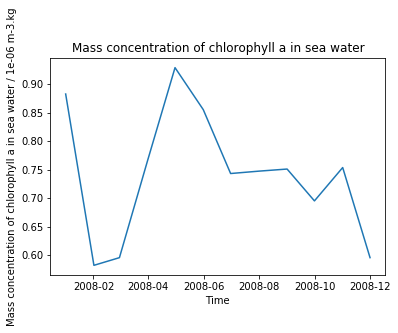

In [78]:
qplt.plot(obs_cube_all_monthly_mon_means.collapsed(['latitude','longitude'],iris.analysis.MEAN))

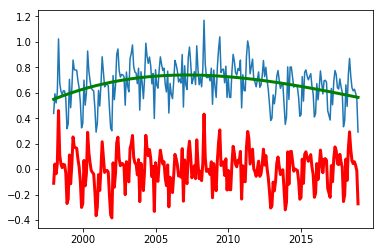

In [79]:
from scipy.interpolate import UnivariateSpline

y = obs_cube_all_monthly.collapsed(['latitude','longitude'],iris.analysis.MEAN).data
x = obs_cube_all_monthly.coord('year').points + (obs_cube_all_monthly.coord('month').points-1.0)/12.0

spl = UnivariateSpline(x, y)
xs = x
plt.plot(x, y)
plt.plot(xs, spl(xs), 'g', lw=3)

plt.plot(x, y - spl(xs), 'r', lw=3)




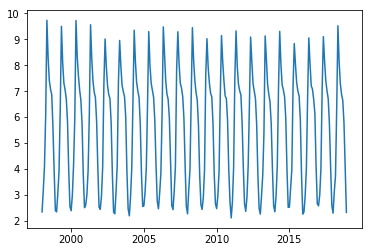

In [80]:
from scipy.interpolate import UnivariateSpline

y = cube_all_monthly.collapsed(['latitude','longitude'],iris.analysis.MEAN).data
x = cube_all_monthly.coord('year').points + (cube_all_monthly.coord('month').points-1.0)/12.0

# spl = UnivariateSpline(x, y)
# xs = x
plt.plot(x, y)
# plt.plot(xs, spl(xs), 'g', lw=3)

# plt.plot(x, y - spl(xs), 'r', lw=3)


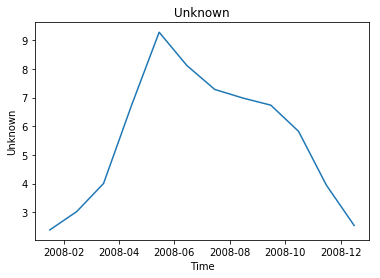

In [81]:
qplt.plot(cube_all_monthly_mon_means.collapsed(['latitude','longitude'],iris.analysis.MEAN))

In [82]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import iris.coord_categorisation
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import iris.coord_categorisation
import glob
import pandas as pd
import datetime



files = glob.glob('/Users/ph290/Downloads/SmartBuoy-Downloaded-Data-2020-06-30T12_37_24/*.csv')
# for infor about the diff fluorescence methods see https://hal.archives-ouvertes.fr/hal-01097870/document

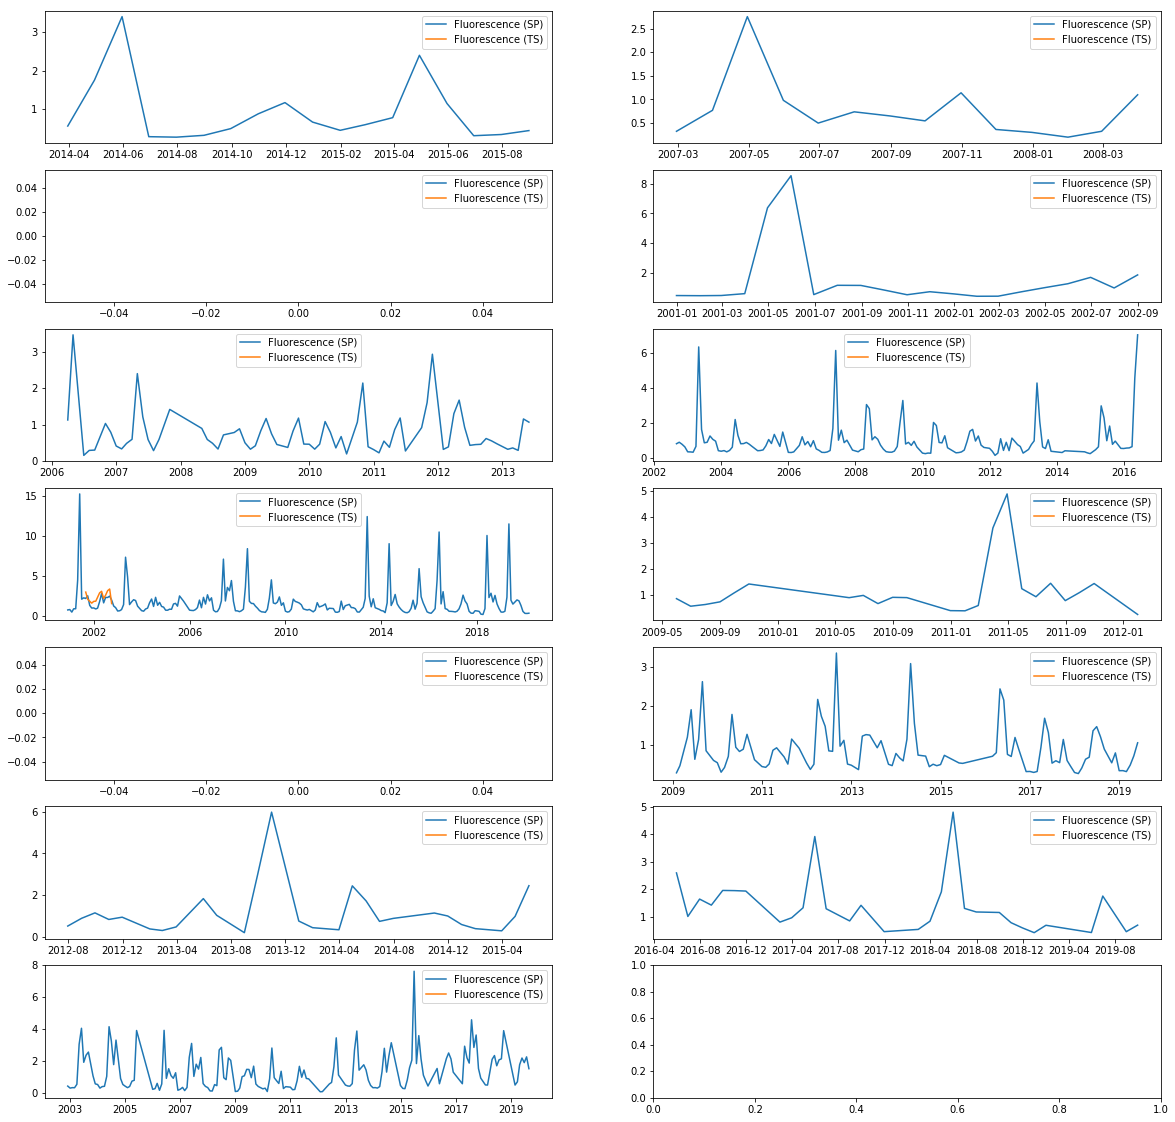

In [83]:
# fig, ax = plt.subplots(len(files),figsize=(10,10))

fig, axs = plt.subplots(int(np.floor(len(files)/2.0)), 2,figsize=(20,20))

# "ravel" flattens the numpy array without making a copy
for i,ax in enumerate(axs.ravel()):
    try:
        file = files[i]
        df = pd.read_csv(file)
        df['datetime'] = pd.to_datetime(df['Time (GMT)'], format='%Y-%m-%d %H:%M:%S')
        df = df.set_index('datetime')
        df = df.resample('M').mean()
        # list(df)
        
#         loc = np.isfinite(df['Fluorescence (MT) (arb. unit) at 1 m'].values)
#         ax.plot(df.index.values[loc],df['Fluorescence (MT) (arb. unit) at 1 m'].values[loc],label='Fluorescence (MT)')

        loc = np.isfinite(df['Fluorescence (SP) (arb. unit) at 1 m'].values)
        ax.plot(df.index.values[loc],df['Fluorescence (SP) (arb. unit) at 1 m'].values[loc],label='Fluorescence (SP)')

        loc = np.isfinite(df['Fluorescence (TS) (arb. unit) at 1 m'].values)
        ax.plot(df.index.values[loc],df['Fluorescence (TS) (arb. unit) at 1 m'].values[loc],label='Fluorescence (TS)')

        ax.legend()
    except:
        pass


In [84]:
sites = {}
sites['candyfloss-nerc-ssb-smartbuoy'] = [53.167,2.817]
sites['north-dogger-smartbuoy-for-e3205'] = [55.683,2.280]
sites['noordwijk-5-smartbuoy'] = [52.276,4.367]
sites['gabbard-nmmp-smartbuoy'] = [52.000,2.335]
sites['oyster-ground-smartbuoy'] = [54.414,4.039]
sites['west-gabbard-smartbuoy'] = [51.980,2.083]
sites['warp-(th1)-nmmp-smartbuoy'] = [51.526,1.028]
sites['celtic-deep-smartbuoy'] = [51.250,-6.082]
sites['noordwijk-2-smartbuoy'] = [52.255,4.404]
sites['dowsing-smartbuoy'] = [53.531,1.056]
sites['celtic-deep-smartbuoy-site-2'] = [51.138,-6.562]
sites['west-gabbard-2-smartbuoy'] = [51.955,2.110]
sites['liverpool-bay-coastal-observatory'] = [53.535,-3.362]
# sites['west-of-ireland-m1-buoy'] = [-9999.9,-9999.9]
sites['noordwijk-10-smartbuoy'] = [52.301,4.303]


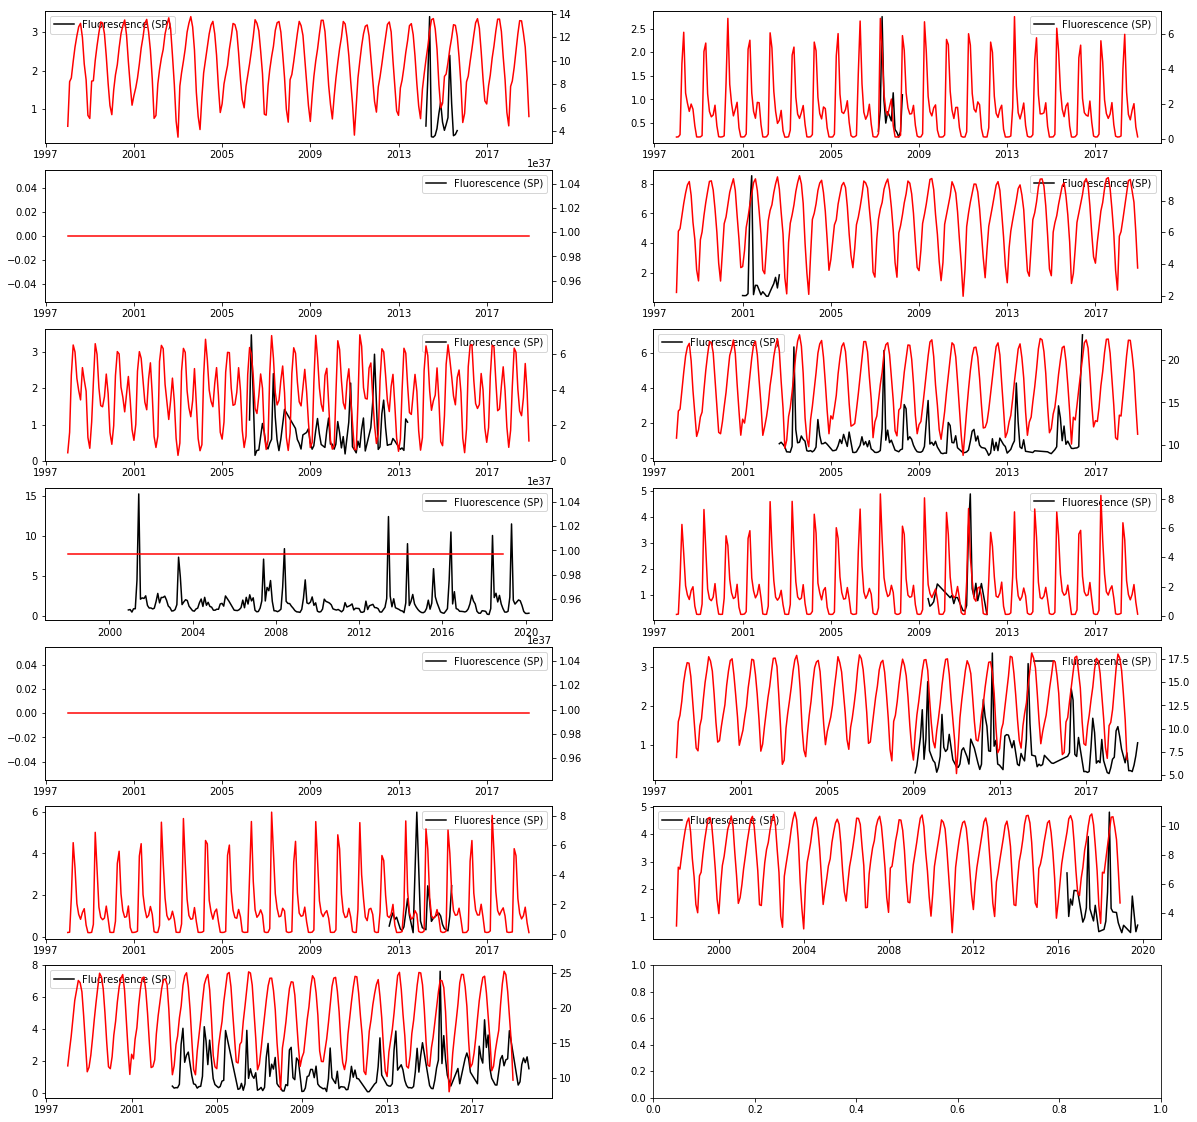

In [102]:
# fig, ax = plt.subplots(len(files),figsize=(10,10))

fig, axs = plt.subplots(int(np.floor(len(files)/2.0)), 2,figsize=(20,20))

# "ravel" flattens the numpy array without making a copy
for i,ax in enumerate(axs.ravel()):
    try:
        file = files[i]
        df = pd.read_csv(file)
        df['datetime'] = pd.to_datetime(df['Time (GMT)'], format='%Y-%m-%d %H:%M:%S')
        df = df.set_index('datetime')
        df = df.resample('M').mean()
        # list(df)
        
        
#         loc = np.isfinite(df['Fluorescence (MT) (arb. unit) at 1 m'].values)
#         ax.plot(df.index.values[loc],df['Fluorescence (MT) (arb. unit) at 1 m'].values[loc],label='Fluorescence (MT)')

        loc = np.isfinite(df['Fluorescence (SP) (arb. unit) at 1 m'].values)
        ax.plot(df.index.values[loc],df['Fluorescence (SP) (arb. unit) at 1 m'].values[loc],'k',label='Fluorescence (SP)')

#         loc = np.isfinite(df['Fluorescence (TS) (arb. unit) at 1 m'].values)
#         ax.plot(df.index.values[loc],df['Fluorescence (TS) (arb. unit) at 1 m'].values[loc],label='Fluorescence (TS)')
    
        #model
        lat,lon = sites[file.split('/')[-1].split('.')[0]]

        lat_model = cube_all_monthly.coord('latitude')
        lon_model = cube_all_monthly.coord('longitude')
        lat_coord1 = lat_model.nearest_neighbour_index(lat)
        lon_coord1 = lon_model.nearest_neighbour_index(lon)
        site_timeseries = cube_all_monthly.data[:,lat_coord1,lon_coord1].data
        years, months = cube_all_monthly.coord('year').points,cube_all_monthly.coord('month').points
        model_dates = [datetime.date(y,m,1) for y, m in zip(years, months)]

        ax2 = ax.twinx()
        plt.plot(model_dates,site_timeseries,'r')

        ax.legend()
    except:
        pass
